In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
data = bmb.load_data("cherry_blossoms")
data

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


In [4]:
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.shape

(827, 5)

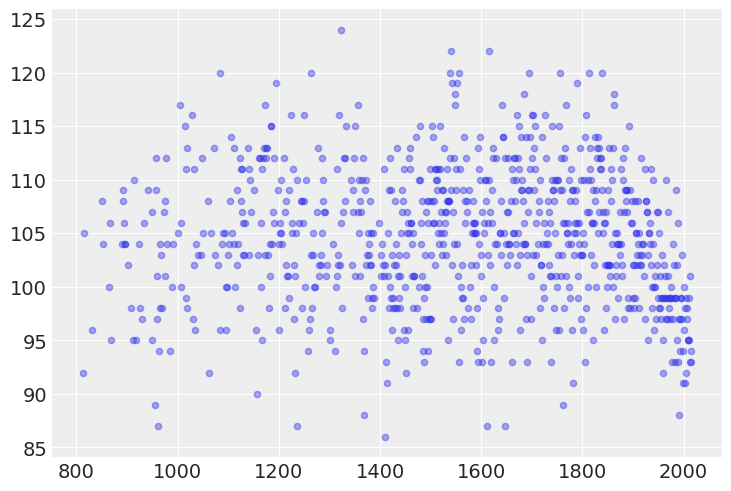

In [5]:
_, ax = plt.subplots()

ax.scatter(data["year"], data["doy"], alpha=0.4, s=20);

In [6]:
num_knots = 15
knots = np.quantile(data.year, np.linspace(0, 1, num_knots))
knots = knots[1:-1]

In [7]:
priors = {"common": bmb.Prior("Normal", mu=0, sigma=10)}
model = bmb.Model("doy ~ bs(year, knots=knots)", data, priors=priors)
model

Formula: doy ~ bs(year, knots=knots)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 10)
    bs(year, knots = knots) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 6.4032)


In [8]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = knots), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


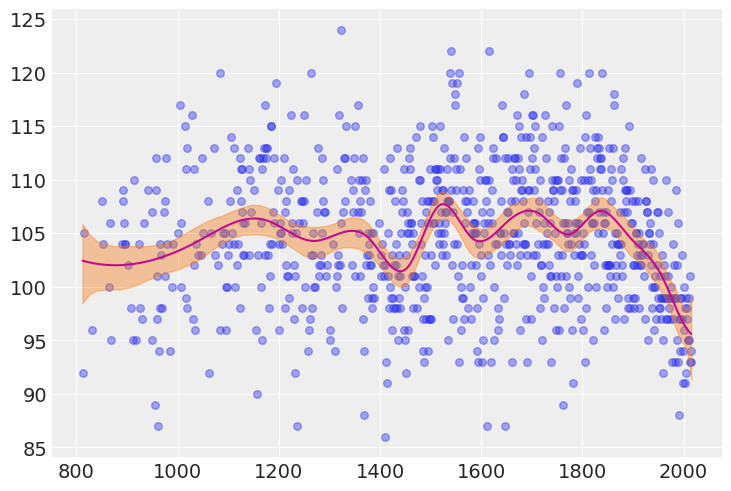

In [9]:
_, ax = plt.subplots()

new_data = pd.DataFrame({"year": np.linspace(data.year.min(), data.year.max(), num=500)})
model.predict(idata, data=new_data)

y_pred = idata.posterior.doy_mean.values
y_pred_mean = y_pred.mean((0, 1))
hdi_data = np.quantile(y_pred, [0.03, 0.94], axis=(0, 1))

plt.scatter(data["year"], data["doy"], alpha=0.4, s=30)
plt.plot(new_data["year"], y_pred_mean, color="C3")
plt.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="C1");